In [1]:
from instruments.M8195A_driver import * # awg
from instruments.VisaInstrument import * # awg
from instruments.pulse_generator import *
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas
import math


import timeit
from importlib import reload

In [2]:
x,pulse,marker =prepareMeasurementSignalData(200e-9,70e6,awgRate)

NameError: name 'awgRate' is not defined

In [55]:
pulse = addPadding(pulse)
marker = addPadding(marker)

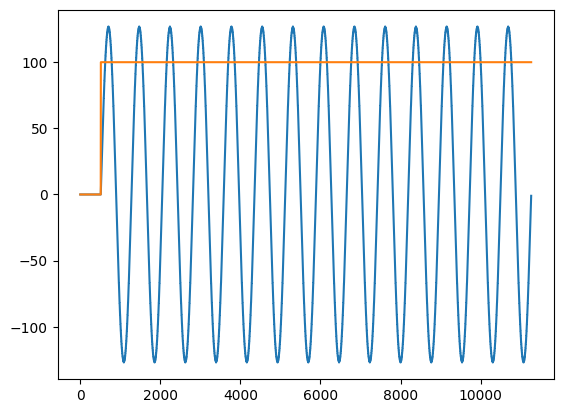

In [57]:
plt.plot(pulse)
plt.plot(marker*100)

In [59]:
withmarker = np.array(tuple(zip(pulse,marker))).flatten()

In [62]:
withmarker

array([ 0,  0,  0, ...,  1, -1,  1], dtype=int8)

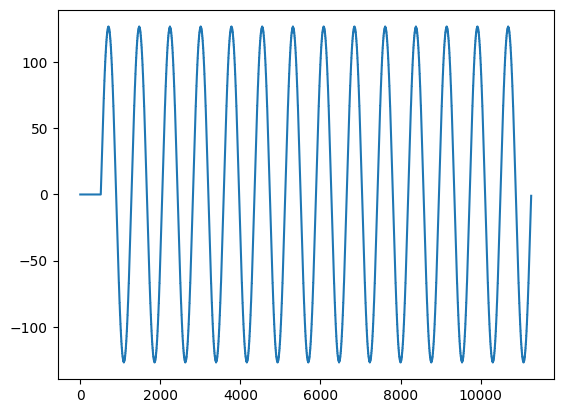

In [61]:
plt.plot(withmarker[::2])

In [3]:
awg = M8195A_driver('169.254.101.100')

In [9]:
awg.getError()

Your command:  has errors:
-300,"Device-specific error;Operation not allowed while instrument is started. Please stop first."


In [6]:
awg.getChannelMemorySetting(1)

'EXT'

In [266]:
awg.setChannelMemoryToExtended(2)

In [232]:
awg.getChannelSetting()

'DCM'

In [264]:
awg.setMemoryDivision(2)

In [265]:
awg.getMemoryDivision()

'DIV2'

In [37]:
awg.getChannelSetting()

'MARK'

In [10]:
awg.setDual()

In [36]:
awg.setSingleWithMarker()

In [260]:
awg.setDualWithMarker()

In [14]:
awg.setRefInClockFrequency(10e6)

In [15]:
awg.setRefInClockExternal()

In [16]:
def getDataFromSocketBinary(session):
    dat = b''
    while 1:
        message = session.recv(4096)
        last=len(message)
        if chr(message[-1]) == "\n":
            dat=dat+message[:-1]
            return dat
        else:
            dat=dat+message

In [17]:
def getIEEEBlockTag(data):
    dataSize = len(data)
    numberLength =  int(np.log10(dataSize)+1)
    return "#{}{}".format(numberLength,dataSize)

In [18]:
def downloadDataToAwg(data,channel,offset):
    tag = getIEEEBlockTag(data)
    cmd = ":TRAC{}:DATA 1,{},".format(channel,offset) + tag
    awg._session.sendall(cmd.encode()+bytes(data)+"\n".encode())    


In [19]:
def prepareSignalData(measurementPulseLength,
                      excitationPulsesLength,
                      excitationPulsesDelay,
                      excitationPulsesPhase,
                      freq,
                      excitation_freq,
                      awgRate,
                      markerValueForExcitation=2,
                      markerValueForMeasurement=1):
    measurementPulseLength = np.ceil(measurementPulseLength*freq*2)/freq/2

    for i in range(len(excitationPulsesLength)):
        excitationPulsesLength[i] = np.ceil(excitationPulsesLength[i]*excitation_freq*2)/excitation_freq/2

    # for i in range(len(excitationPulsesDelay)):
    #     excitationPulsesDelay[i] = np.ceil(excitationPulsesDelay[i]*excitation_freq*2)/excitation_freq/2
    
    totalLength = np.sum(excitationPulsesLength) + np.sum(excitationPulsesDelay)  + measurementPulseLength
    
    x = np.arange(0,totalLength,1/awgRate)
    
    size = len(x)
    pulsesExcitation = np.zeros(size,dtype=np.int8)
    pulseMeasurement = np.zeros(size,dtype=np.int8)
    pulseMarkers = np.zeros(size,dtype=np.int8)
    
    
    pos = 0
    timeDuration = 0
    for i in range(len(excitationPulsesLength)):
        xExcitation = np.arange(0,excitationPulsesLength[i],1/awgRate)# + timeDuration
        awgOscExcitation = np.array((2**7-1)*np.sin(2*np.pi*(excitation_freq)*xExcitation+excitationPulsesPhase[i]),dtype=np.int8)
    
        end = pos+len(awgOscExcitation)
        pulsesExcitation[pos:end] = awgOscExcitation
        pulseMarkers[pos:end] = markerValueForExcitation
    
        pos = end + int(excitationPulsesDelay[i]*awgRate)
        #timeDuration += excitationPulsesDelay[i] + excitationPulsesLength[i]
    
    xMeasurement = np.arange(0,measurementPulseLength,1/awgRate)
    awgOscMeasurement = np.array((2**7-1)*np.sin(2*np.pi*(freq)*xMeasurement),dtype=np.int8)
    
    pulseMeasurement[-len(awgOscMeasurement):] = awgOscMeasurement
    pulseMarkers[-len(awgOscMeasurement):] = markerValueForMeasurement
    pulseMarkers[-1]=0

    return x,pulseMeasurement,pulsesExcitation,pulseMarkers

In [20]:
def prepareMeasurementSignalData(measurementPulseLength,freq,awgRate,markerValueForMeasurement=1):
    # This is to guarantee that it is only half a period oscillation
    measurementPulseLength = np.ceil(measurementPulseLength*freq*2)/freq/2
    
    xMeasurement = np.arange(0,measurementPulseLength,1/awgRate)
    awgOscMeasurement = np.array((2**7-1)*np.sin(2*np.pi*(freq)*xMeasurement),dtype=np.int8)
    pulseMarkers = np.ndarray(len(xMeasurement),dtype=np.int8)
    pulseMarkers.fill(markerValueForMeasurement)
    pulseMarkers[-1]=0

    return xMeasurement,awgOscMeasurement,pulseMarkers

In [21]:
def addPadding(pulses,padding = 512):
    addedZerosLength = len(pulses)%padding
    return np.append(np.zeros(padding-addedZerosLength,dtype=np.int8),pulses)

In [280]:
exct_freq = 2150e6
freq = 70e6
numberOfChannels =1
periodPerPacket,awgRate,sampleSizePacket = findAwgRateAndPeriod(freq,numberOfChannels)
awgRate = awgRate/2
awg.set_sampleRate(awgRate*2)


In [271]:
awg.stop()

In [245]:
sampleSizeMeasurement=int(200e-9*awgRate/512)*512

In [246]:
sampleSizeMeasurement

5120

In [281]:
x,pulseMeasurement,pulsesExcitation,pulseMarkers = prepareSignalData(10e-9,[10e-9,5e-9,20e-9,],[10e-9,7e-9,15e-9],[0,0,60],freq,2150e6,awgRate)

In [288]:
# add a number of bytes so that the size of the wave should be a multiple of 256
pulseMeasurement = addPadding(pulseMeasurement)
pulsesExcitation = addPadding(pulsesExcitation)
pulseMarkers = addPadding(pulseMarkers)

In [112]:
len(pulseMeasurement)

512

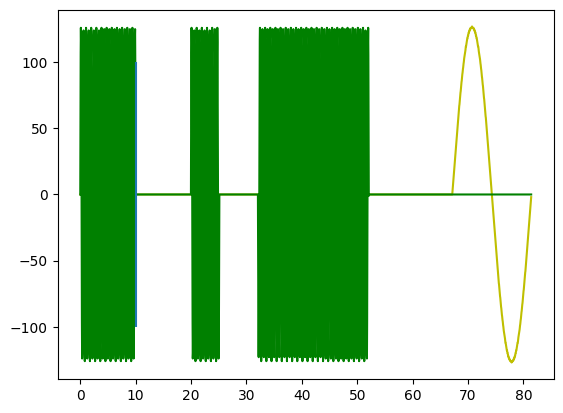

In [282]:
plt.plot(x*1e9,pulseMeasurement,c='y')
plt.plot(x*1e9,pulsesExcitation,c='g')
plt.vlines(10,-100,100)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (841,) and (1024,)

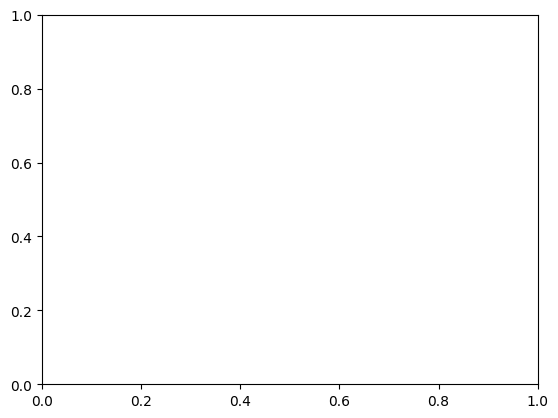

In [67]:
plt.plot(x*1e9a,pulsesExcitation)
plt.plot(x*1e9,pulseMeasurement)
plt.xlim(0,5)

In [70]:
1/70e6*1e9

14.285714285714286

In [289]:
withmarker = np.array(tuple(zip(pulseMeasurement,pulseMarkers))).flatten()

In [209]:
sampleSizeMeasurement

2560

In [292]:
awg.getError()

In [227]:
awg.stop()

In [290]:
SCPI_sock_send(awg._session,":TRAC1:DEL:ALL")
SCPI_sock_send(awg._session,":TRAC2:DEL:ALL")
SCPI_sock_send(awg._session,":TRAC1:DEF 1,{},0".format(sampleSizeMeasurement))
sleep(1)
awg.getError()

In [291]:
downloadDataToAwg(pulsesExcitation, 2,0)
sleep(0.1)
downloadDataToAwg(withmarker, 1,0)

In [195]:
awg.toggleChannelOuput(2)

Checking output state from channel 2.
AWG Response: 0,"No error"
Changing output state.
AWG Response: 0,"No error"


In [293]:
awg.start()

In [197]:
size1 = int(SCPI_sock_query(awg._session,':TRAC1:CAT?').split(',')[1])
print(size1)

2560


In [198]:
size1 = int(SCPI_sock_query(awg._session,':TRAC1:CAT?').split(',')[1])
data1 = SCPI_sock_query(awg._session,':TRAC1:DATA? 1, {},{}'.format(0,int(20e-6*awgRate/512)*512))
print(size1)
x1 = np.array(data1.split(','))
y1 = x1.astype(int)
plt.plot(y1[0::2])
plt.plot(y1[1::2]*50)


2560


ValueError: invalid literal for int() with base 10: ''

In [213]:
SCPI_sock_send(awg._session,":TRAC1:DEL:ALL")
SCPI_sock_send(awg._session,":TRAC2:DEL:ALL")
SCPI_sock_send(awg._session,":TRAC1:DEF 1,{},0".format(sampleSizeMeasurement))
sleep(1)

In [214]:
numberOfChannels = 1
periodPerPacket,awgRate,sampleSizePacket = findAwgRateAndPeriod(if_freq,numberOfChannels)
awgRate = awgRate*numberOfChannels
awg.set_sampleRate(awgRate)

_,pulseMeasurement,markers = prepareMeasurementSignalData(pulseMeasurementLength,if_freq,awgRate)

pulseMeasurement = addPadding(pulseMeasurement)
markers = addPadding(markers)

sampleSizeMeasurement = int(awgRate*pulsesPeriod/512)*512

SCPI_sock_send(awg._session,":TRAC1:DEL:ALL")
SCPI_sock_send(awg._session,":TRAC2:DEL:ALL")
SCPI_sock_send(awg._session,":TRAC1:DEF 1,{},0".format(sampleSizeMeasurement))
sleep(1)
awg.getError()

withmarker = np.array(tuple(zip(pulseMeasurement,markers))).flatten()



In [215]:
awg.downloadDataToAwg(withmarker, 1,0)
awg.getError()

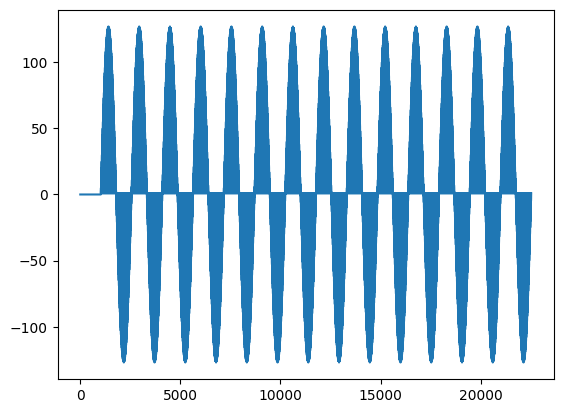

In [216]:
plt.plot(withmarker)

In [412]:
data = getDataFromSocketBinary(awg._session)

In [413]:
data[:256]

b'#521504\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [414]:
curve = np.array(struct.unpack(str(size1)+'b',data[6::2]))
marker = np.array(struct.unpack(str(size1)+'b',data[7::2]))

error: unpack requires a buffer of 10752 bytes

In [103]:
samplingRate=1e9
pointsPerRecord = int(20e-6*samplingRate/256)*256

In [104]:
I,Q = alazar.capture(0,pointsPerRecord,nBuffer,recordPerBuffers,ampReference,save=False,waveformHeadCut=waveformHeadCut, decimation_value = decimation_value, triggerLevel_volts=0.7, triggerRange_volts=1,TTL=True)

In [106]:
I

0.0014176439557044458

In [105]:
Q

-0.0005040289882438175

# Profiling time spent for ASCII method

In [266]:
SCPI_sock_send(awg._session,":TRAC1:DEL:ALL")
SCPI_sock_send(awg._session,":TRAC1:DEF 1,{},0".format(sampleSizePacket))
awg.getError()

In [267]:
def sendData():
    SCPI_sock_send(awg._session, ':TRAC1:DATA 1,{},{}'.format(0,data_str))
    size1 = int(SCPI_sock_query(awg._session,':TRAC1:CAT?').split(',')[1])


##  How long does it take for 1000 download to AWG

In [269]:
awg.getError()

Execution time: 0.018461 seconds


In [262]:
SCPI_sock_send(awg._session, ':TRAC1:DATA 1,{},{}'.format(0,data_str))

In [94]:
size1 = int(SCPI_sock_query(awg._session,':TRAC1:CAT?').split(',')[1])
data1 = SCPI_sock_query(awg._session,':TRAC1:DATA? 1, {},{}'.format(0,size1))
print(size1)

53760


In [95]:
x1 = np.array(data1.split(','))
y1 = x1.astype(int)

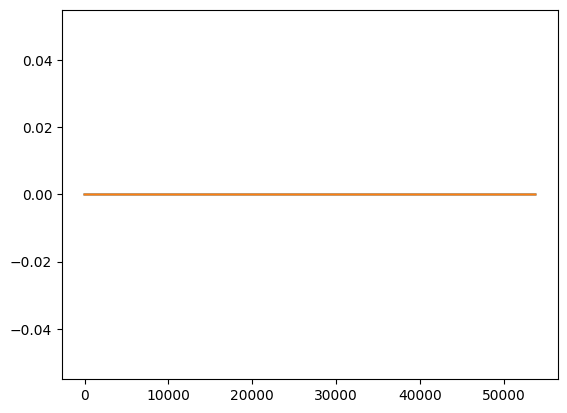

In [96]:
plt.plot(y1[0::2])
plt.plot(y1[1::2])

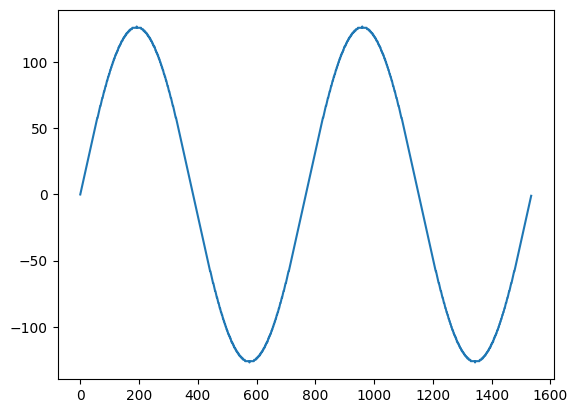

In [279]:
plt.plot(curve)
#plt.xlim(0,100)

# Profiling time spent for binary method

In [35]:
SCPI_sock_send(awg._session,":TRAC1:DEL:ALL")
SCPI_sock_send(awg._session,":TRAC1:DEF 1,{},0".format(sampleSizeMeasurementPulse))
awg.getError()

In [41]:
sampleSizeMeasurementPulse

215040

In [40]:
int(np.log10(sampleSizeMeasurementPulse)+1)

6

In [42]:
def sendData():
    awg._session.sendall(":TRAC1:DATA 1,0,#6215040".encode()+bytes(awgOsc)+"\n".encode())
    size1 = int(SCPI_sock_query(awg._session,':TRAC1:CAT?').split(',')[1])


## How long does it take for 1000 download to AWG

In [43]:
execution_time = timeit.timeit(sendData, number=1)

In [44]:
awg.getError()

In [45]:
print(f"Execution time: {execution_time:.6f} seconds")

Execution time: 0.006892 seconds


In [46]:
size1 = int(SCPI_sock_query(awg._session,':TRAC1:CAT?').split(',')[1])
data1 = SCPI_sock_query(awg._session,':TRAC1:DATA? 1, {},{}'.format(0,size1))
print(size1)

215040


In [47]:
x1 = np.array(data1.split(','))
y1 = x1.astype(int)

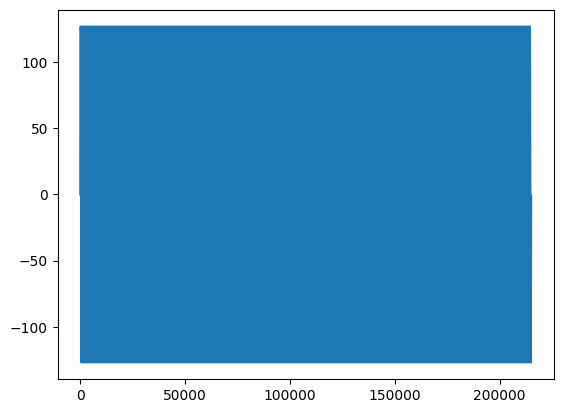

In [48]:
plt.plot(y1)

In [140]:
att.set_attenuation(20)

In [301]:
RFsourceMeasurement.set_frequency(7350e6-70e6)
RFsourceMeasurement.start_rf()
RFsourceExcitation.set_frequency(2150e6)
RFsourceExcitation.stop_rf()

In [302]:
awg.openChanneloutput(1)
awg.openChanneloutput(2)
awg.openChanneloutput(3)
awg.openChanneloutput(4)
awg.start()

In [303]:
samplingRate=1e9
pointsPerRecord = int(5e-6*samplingRate/256)*256

In [304]:
I,Q = alazar.capture(0,pointsPerRecord,nBuffer,recordPerBuffers,ampReference,save=True,waveformHeadCut=waveformHeadCut, decimation_value = decimation_value, triggerLevel_volts=0.7, triggerRange_volts=1,TTL=True)

In [305]:
amplin= np.sqrt(I**2+Q**2)

In [306]:
20*np.log10(amplin)

-43.67111478037444

In [292]:
f = open('data.bin','rb')
data = f.read()
f.close()

In [293]:
a = np.frombuffer(data, dtype=np.uint8)

In [307]:
import pandas

In [308]:
dfhigh = pandas.read_csv('dataIQ_high.csv') #excited
dflow = pandas.read_csv('dataIQ_low.csv') #excited

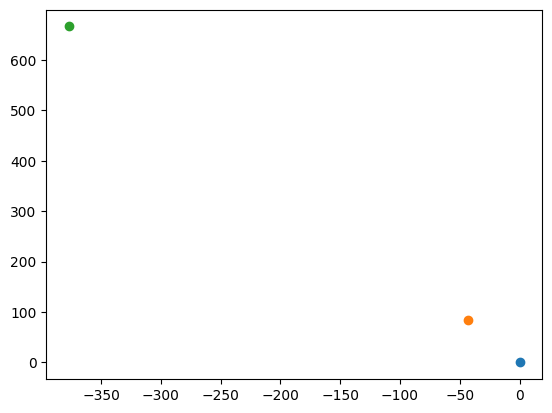

In [309]:
plt.scatter(0,0)
plt.scatter(np.mean(dfhigh['I'])*1e6,np.mean(dfhigh['Q'])*1e6)
plt.scatter(np.mean(dflow['I'])*1e6,np.mean(dflow['Q'])*1e6)

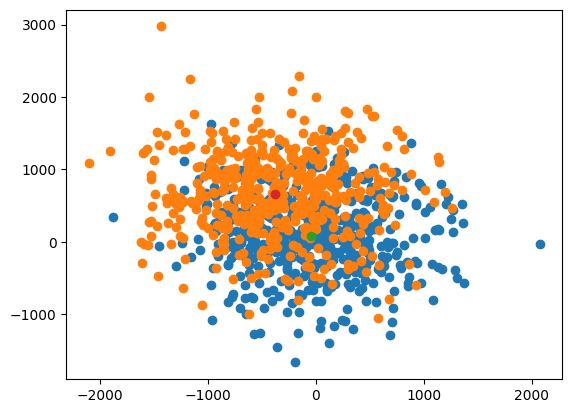

In [310]:
plt.scatter(dfhigh['I']*1e6,dfhigh['Q']*1e6)
plt.scatter(dflow['I']*1e6,dflow['Q']*1e6)
plt.scatter(np.mean(dfhigh['I'])*1e6,np.mean(dfhigh['Q'])*1e6)
plt.scatter(np.mean(dflow['I'])*1e6,np.mean(dflow['Q'])*1e6)


(0.0, 256.0)

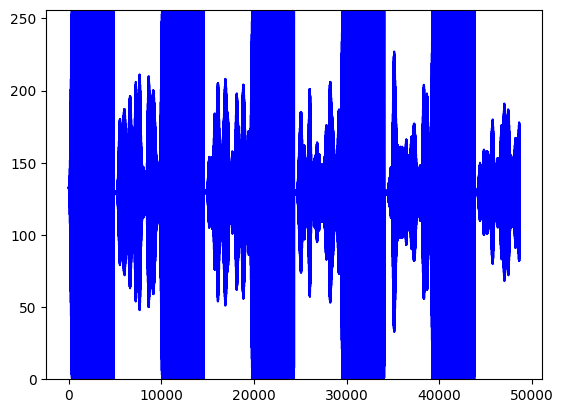

In [294]:
plt.plot(a[:pointsPerRecord*10],color='blue')
#plt.plot(a[pointsPerRecord:pointsPerRecord*2],color='orange')
plt.ylim(0,256)

(1600.0, 1700.0)

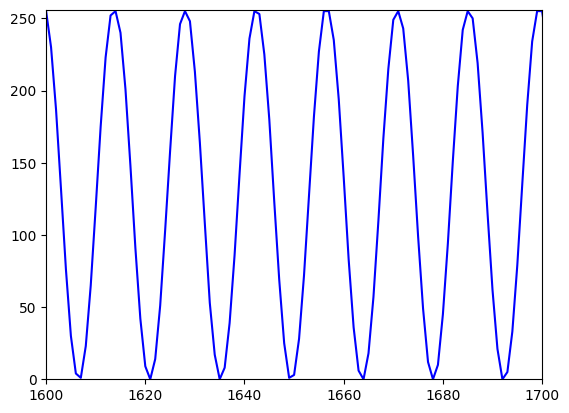

In [150]:
plt.plot(a[:pointsPerRecord*10],color='blue')
#plt.plot(a[pointsPerRecord:pointsPerRecord*2],color='orange')
plt.ylim(0,256)
plt.xlim(1600,1700)

# TESTING AWG MEASUREMENTS

In [1]:
from instruments.ATS9872_driver import * # alazar
from instruments.DG645_driver import * # delay generator
from instruments.M8195A_driver import * # awg
from instruments.E8257D_driver import * #RF source
from instruments.Agilent11713C_driver import * # attenuator
from instruments.SIM928_driver import * # Voltage source
from instruments.SIM970_driver import * # Voltage meter
from instruments.E5063A_driver import * #Vector network analyser

import numpy as np
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas
import math

In [2]:
import measurements.sweep_pulse as sweep_pulse
import measurements.rabi as rabi
import measurements.rabi_map as rabi_map
import measurements.echo as echo
import measurements.T1 as T1
import measurements.ramsey as ramsey
import measurements.ramsey_map as ramsey_map
import measurements.powersweep_pulse as powersweep_pulse
import measurements.fluxsweep_pulse as fluxsweep_pulse
import measurements.twotone_pulse as twotone_pulse
import measurements.T1_map as T1_map
import measurements.vna as vna


import measurements.powersweep as powersweep
import measurements.fluxsweep as fluxsweep
import measurements.twotone as twotone

In [3]:
from importlib import reload

In [4]:
awg = M8195A_driver('169.254.101.100')

In [5]:
alazar = ATS9872_driver()

att = Agilent11713C_driver('TCPIP0::169.254.101.101::inst0::INSTR')
RFsourceMeasurement = E8257D_driver('TCPIP0::169.254.101.103::inst0::INSTR')
#RFsourceExcitation = E8257D_driver('TCPIP0::169.254.101.104::inst0::INSTR')
Voltsource = SIM928_driver('GPIB0::2::INSTR',8,step_time=0.1,step_voltage=0.01) # voltsouce step_time, step_voltage
Voltmeter = SIM970_driver('GPIB0::2::INSTR',5)

In [30]:
att.set_attenuation(94)

In [137]:
reload(sweep_pulse)

<module 'measurements.sweep_pulse' from 'C:\\Users\\Franscisco Rouxinol\\Developer\\MeasurementLFDQ\\src\\measurements\\sweep_pulse.py'>

In [153]:
voltage = -0.15
rf_amp = 18 # amp na saida

attenuator_att = 20
center_freq = 7350e6
span_freq = 30e6
step_freq = 1e6
if_freq = 70e6
qubitname = 'olivier_sample'
voltageSourceState = True
nBuffer = 200
recordPerBuffers = 500
waveformHeadCut = 500
pulsesPeriod = 580e-6
pulseLength = 5e-6
ampReference = -9 # this does not affect the measurement. mudei para ficar mais facil ver o sinal
decimation_value = 1 #  1 GHz/ decimation_value


excitationState = False
excitationDuration = 800e-9
excitationAmplitude = 0.2
excitationFrequency = 2150e6

In [154]:
awg.getError()

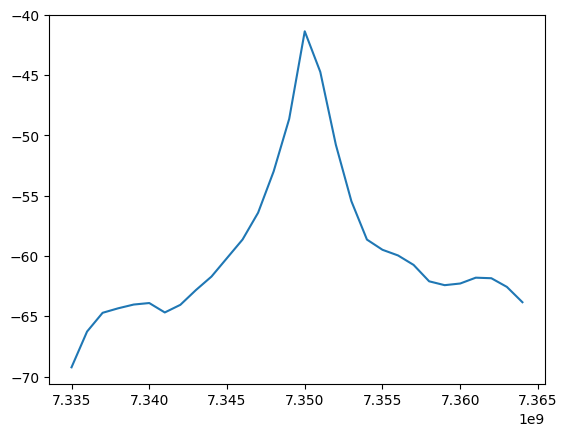

'olivier_sample_20231024_2007_sweep_pulse_cfreq_7350.npz'

In [155]:
sweep_pulse.measure(alazar,
                    awg, 
                    att,
                    RFsourceMeasurement,
                    Voltsource,
                    voltage,
                    rf_amp,
                    attenuator_att, 
                    center_freq,
                    span_freq,
                    step_freq, 
                    if_freq,
                    qubitname,
                    voltageSourceState, 
                    excitationState,
                    excitationDuration,
                    excitationAmplitude,
                    excitationFrequency, 
                    nBuffer, 
                    recordPerBuffers, 
                    waveformHeadCut,
                    pulsesPeriod,
                    pulseLength,
                    ampReference,
                    decimation_value,
                   currentResistance = 1e3)

In [156]:

excitationState = True
excitationDuration = 800e-9
excitationAmplitude = 0.2
excitationFrequency = 2150e6

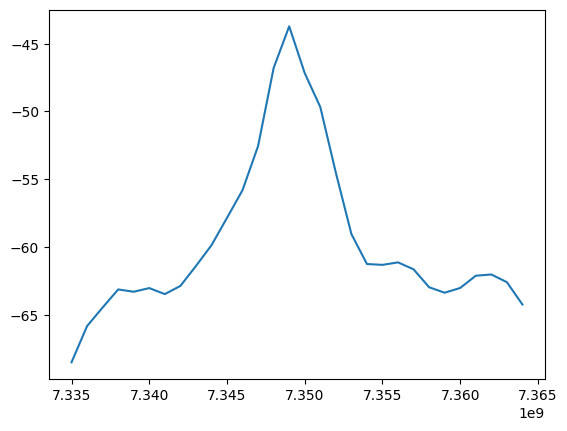

'olivier_sample_20231024_2037_sweep_pulse_cfreq_7350.npz'

In [157]:
sweep_pulse.measure(alazar,
                    awg, 
                    att,
                    RFsourceMeasurement,
                    Voltsource,
                    voltage,
                    rf_amp,
                    attenuator_att, 
                    center_freq,
                    span_freq,
                    step_freq, 
                    if_freq,
                    qubitname,
                    voltageSourceState, 
                    excitationState,
                    excitationDuration,
                    excitationAmplitude,
                    excitationFrequency, 
                    nBuffer, 
                    recordPerBuffers, 
                    waveformHeadCut,
                    pulsesPeriod,
                    pulseLength,
                    ampReference,
                    decimation_value,
                   currentResistance = 1e3)

In [158]:
data_low = np.load('olivier_sample_20231024_2007_sweep_pulse_cfreq_7350.npz')
data_high = np.load('olivier_sample_20231024_2037_sweep_pulse_cfreq_7350.npz')

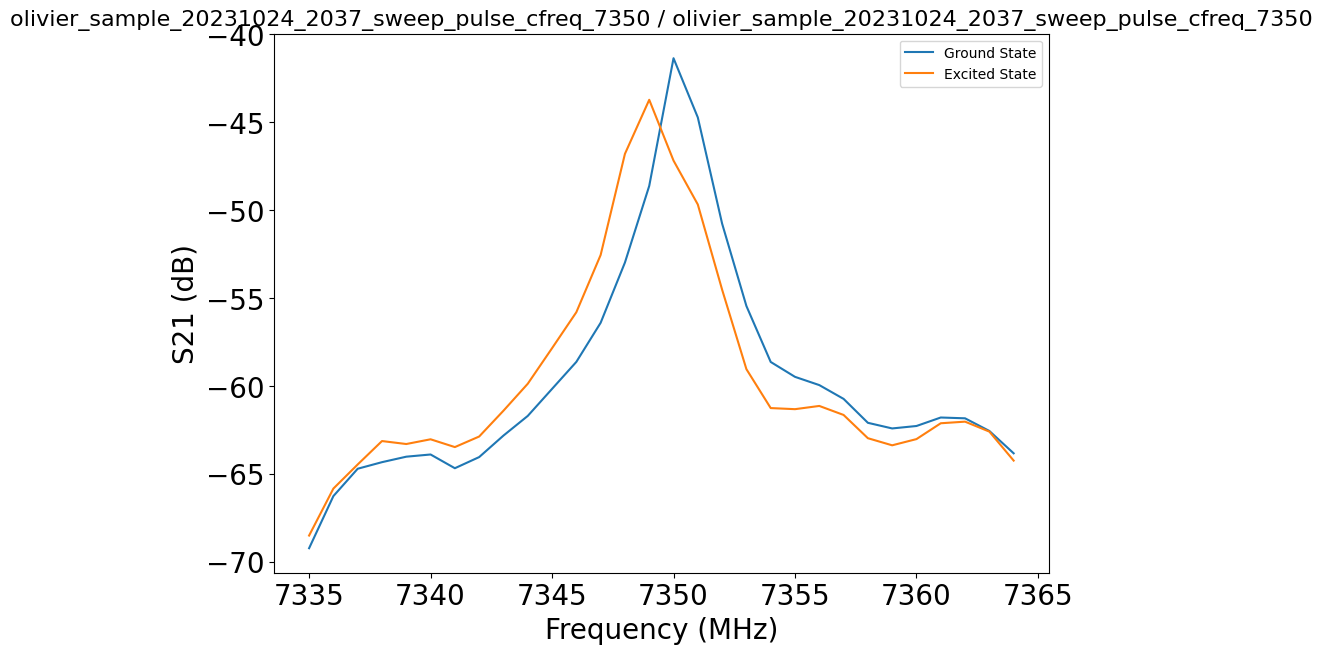

In [163]:
#HOW TO PLOT
freqs = data_low['freqs']
mag_low = np.abs(data_low['Z'])
mag_high = np.abs(data_high['Z'])
fig = plt.figure(figsize=(10,7))
ax = fig.gca()
plt.plot(freqs*1e-6,20*np.log10(mag_low))
plt.plot(freqs*1e-6,20*np.log10(mag_high))
ax.tick_params(labelsize=20)
ax.set_xlabel('Frequency (MHz)',fontsize=20)
ax.set_ylabel('S21 (dB)',fontsize=20)
ax.set_title('olivier_sample_20231024_2037_sweep_pulse_cfreq_7350 / olivier_sample_20231024_2037_sweep_pulse_cfreq_7350',fontsize=16)
plt.legend(['Ground State','Excited State'])
plt.show()

In [99]:
reload(powersweep_pulse)

<module 'measurements.powersweep_pulse' from 'C:\\Users\\Franscisco Rouxinol\\Developer\\MeasurementLFDQ\\src\\measurements\\powersweep_pulse.py'>

In [96]:
voltage = 0.16
rf_amp = 18
attenuator_att_init = 0
attenuator_att_final = 60
attenuator_att_step = 5
center_freq = 7350e6
span_freq =50e6
step_freq = 0.5e6
if_freq = 70e6
qubitname = 'olivier_sample'
voltageSourceState = True
nBuffer = 20
recordPerBuffers = 25
waveformHeadCut = 500
pulsesPeriod = 580e-6
pulseLength = 5e-6
ampReference = -9
decimation_value = 1 #  1 GHz/ decimation_value


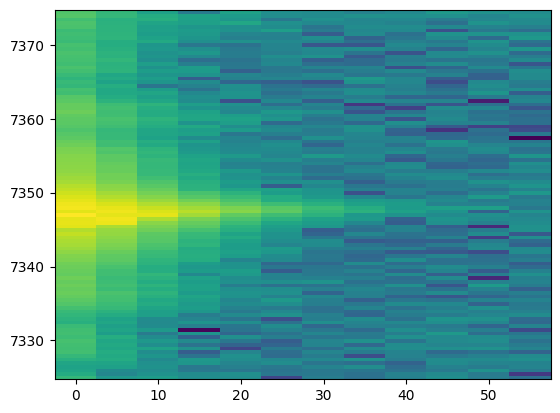

'olivier_sample_20231018_0033_powersweep_pulse_cfreq_7350.npz'

In [97]:
powersweep_pulse.measure(alazar,
                         awg,
                         att,
                         RFsourceMeasurement,
                         Voltsource,
                         voltage,
                         rf_amp,
                         attenuator_att_init,
                         attenuator_att_final,
                         attenuator_att_step, 
                         center_freq,
                         span_freq,
                         step_freq, 
                         if_freq, 
                         qubitname,
                         voltageSourceState,  
                         nBuffer, 
                         recordPerBuffers, 
                         waveformHeadCut,
                         pulsesPeriod,
                         pulseLength,
                         ampReference,
                         decimation_value,
                        currentResistance=1e3)

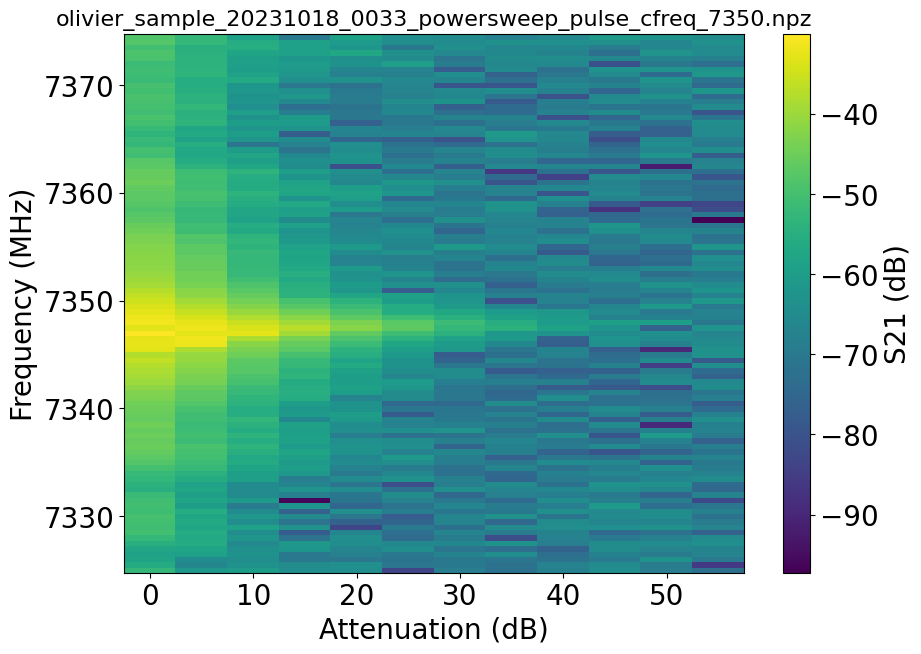

In [100]:
powersweep_pulse.plot('olivier_sample_20231018_0033_powersweep_pulse_cfreq_7350.npz')

# fluxsweep pulsed

In [192]:
reload(fluxsweep_pulse)

<module 'measurements.fluxsweep_pulse' from 'C:\\Users\\Franscisco Rouxinol\\Developer\\MeasurementLFDQ\\src\\measurements\\fluxsweep_pulse.py'>

In [70]:
voltage_init = -0.5
voltage_final = 0.5
voltage_step = 0.1

rf_amp = 18
attenuator_att= 20
center_freq = 7350e6
span_freq = 50e6
step_freq = 0.5e6
if_freq = 70e6
qubitname = 'olivier_sample'
voltageSourceState = True
nBuffer = 25
recordPerBuffers = 20
waveformHeadCut = 500
pulsesPeriod = 580e-6
pulseLength = 5e-6
ampReference = -9
currentResistance = 1e3
decimation_value = 1 #  1 GHz/ decimation_value


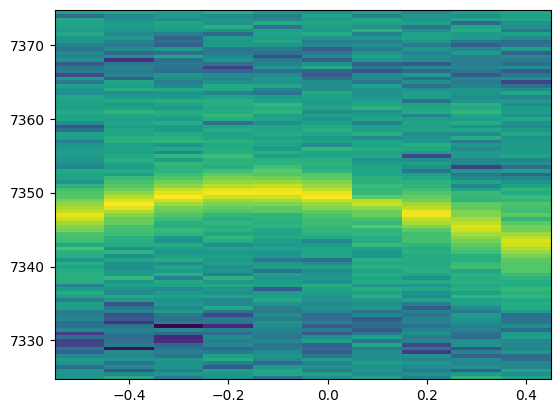

'olivier_sample_20231024_1219_fluxsweep_pulse_cfreq_7350.npz'

In [71]:
fluxsweep_pulse.measure(alazar,
            awg,
            att,
            RFsourceMeasurement,
            Voltsource,
            voltage_init,
            voltage_final,
            voltage_step,
            rf_amp,
            attenuator_att,
            center_freq,
            span_freq,
            step_freq, 
            if_freq,
            qubitname, 
            nBuffer,
            recordPerBuffers,
            waveformHeadCut,
            pulsesPeriod,
            pulseLength,
            ampReference,
            currentResistance,
            decimation_value)

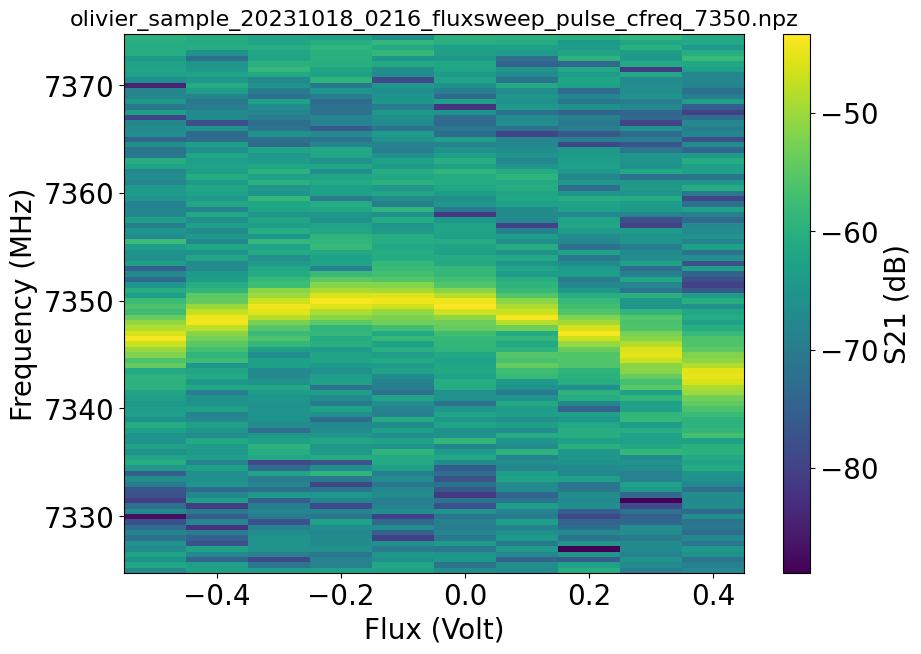

In [193]:
fluxsweep_pulse.plot('olivier_sample_20231018_0216_fluxsweep_pulse_cfreq_7350.npz')

In [417]:
reload(twotone_pulse)

<module 'measurements.twotone_pulse' from 'C:\\Users\\Franscisco Rouxinol\\Developer\\MeasurementLFDQ\\src\\measurements\\twotone_pulse.py'>

In [91]:
voltage = -0.15
attenuator_att = 20
freqMeasurement = 7350e6
if_freq = 70e6
qubitname = 'olivier_sample'
voltageSourceState = True
nBuffer = 25
recordPerBuffers = 50
waveformHeadCut = 500
pulsesPeriod = 580e-6
pulseMeasurementLength = 5e-6
pulseExcitationLength = 20e-6
delayBetweenPulses = 5e-6
ampReference = -9
decimation_value = 1 #  1 GHz/ decimation_value

rf_excitation_amp = 14
rf_measurement_amp= 18

excitationPulseIFAmp = 0.2

RFSource_frequency_initial = 2140e6
RFSource_frequency_final = 2160e6
RFSource_frequency_step = 1e6

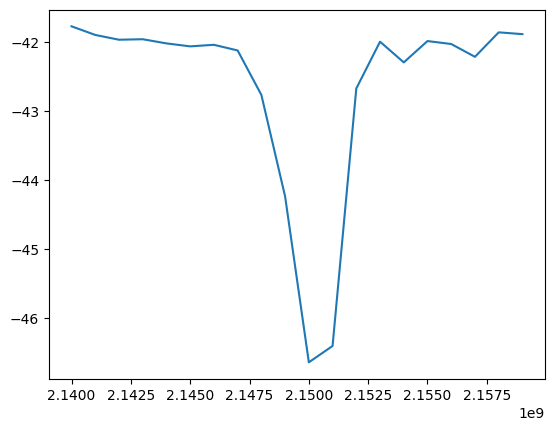

'olivier_sample_20231024_1657_twotone_pulse_cfreq_7350.npz'

In [92]:
twotone_pulse.measure(alazar,
                      awg,
                      att,
                      RFsourceMeasurement,
                      0,
                      Voltsource,
                      freqMeasurement,
                      voltage,
                      rf_excitation_amp,
                      rf_measurement_amp,
                      attenuator_att, 
                      RFSource_frequency_initial,
                      RFSource_frequency_final,
                      RFSource_frequency_step, 
                      if_freq,
                      qubitname,
                      voltageSourceState,
                      nBuffer,
                      recordPerBuffers, 
                      waveformHeadCut,
                      pulsesPeriod,
                      pulseMeasurementLength,
                      delayBetweenPulses,
                      pulseExcitationLength,
                      excitationPulseIFAmp,
                      ampReference,
                      decimation_value,
                     currentResistance=1e3)

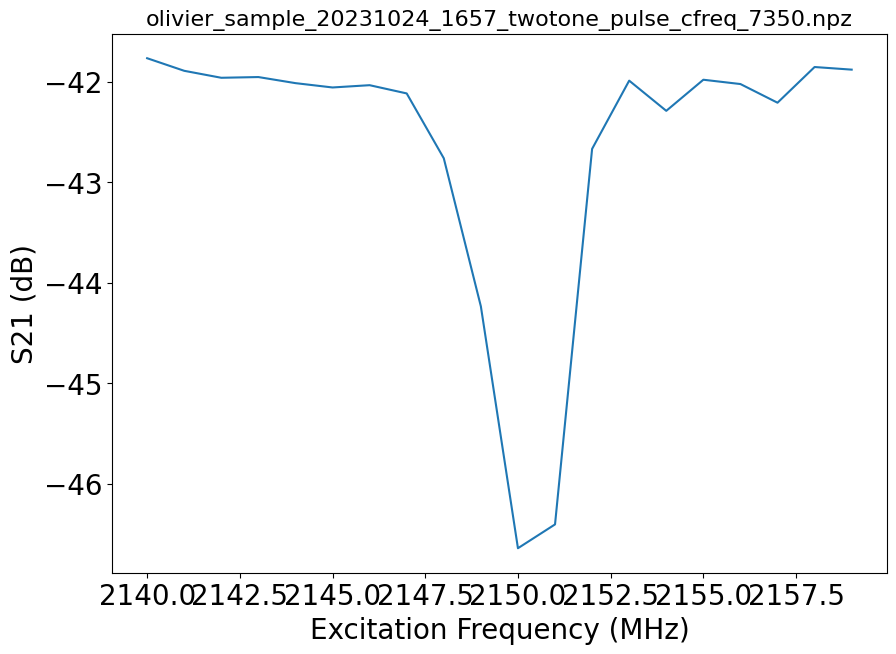

In [164]:
twotone_pulse.plot('olivier_sample_20231024_1657_twotone_pulse_cfreq_7350.npz')

# Rabi Oscillation

In [33]:
reload(rabi)

<module 'measurements.rabi' from 'C:\\Users\\Franscisco Rouxinol\\Developer\\MeasurementLFDQ\\src\\measurements\\rabi.py'>

In [93]:
voltage = -0.15
rf_amp = 18
attenuator_att = 20
freqMeasurement = 7350e6
if_freq = 70e6
qubitname = 'olivier_sample'
voltageSourceState = True
nBuffer =25
recordPerBuffers = 50
waveformHeadCut = 500
pulsesPeriod = 580e-6 # microseconds
pulseMeasurementLength = 5e-6
delayBetweenPulses = 0
ampReference = -9
decimation_value = 1 #  1 GHz/ decimation_value

rf_excitation_amp = 14
rf_measurement_amp= 18
pulseExcitationLength_init = 0e-9 
pulseExcitationLength_final = 2e-6
pulseExcitationLength_step = 100e-9

freqExcitation = 2150e6

excitationPulseIFAmp =200e-3


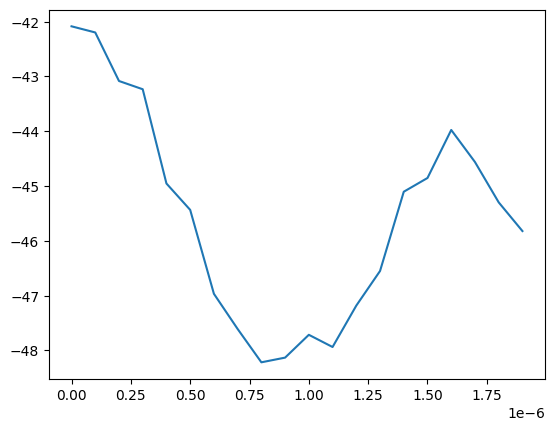

'olivier_sample_20231024_1659_rabi_cfreq_7350.npz'

In [94]:
rabi.measure(alazar,
        awg, 
        att,
        RFsourceMeasurement,
        0,
        Voltsource,
        freqMeasurement,
        freqExcitation,
        voltage,
        rf_excitation_amp,
        rf_measurement_amp,
        attenuator_att,
        pulseExcitationLength_init,
        pulseExcitationLength_final,
        pulseExcitationLength_step,
        excitationPulseIFAmp,
        if_freq, 
        qubitname,
        voltageSourceState,  
        nBuffer, 
        recordPerBuffers, 
        waveformHeadCut,
        pulsesPeriod,
        pulseMeasurementLength,
        delayBetweenPulses,
        ampReference,
        decimation_value,
            currentResistance=1e3)

In [25]:
voltage = -0.15
rf_amp = 18
attenuator_att = 20
freqMeasurement = 7350e6
if_freq = 70e6
qubitname = 'olivier_sample'
voltageSourceState = True
nBuffer =100
recordPerBuffers = 200
waveformHeadCut = 500
pulsesPeriod = 580e-6 # microseconds
pulseMeasurementLength = 5e-6
delayBetweenPulses = 0
ampReference = -9
decimation_value = 1 #  1 GHz/ decimation_value

rf_excitation_amp = 14
rf_measurement_amp= 18
pulseExcitationLength_init = 0e-9 
pulseExcitationLength_final = 50e-6
pulseExcitationLength_step = 300e-9

freqExcitation = 2150e6

excitationPulseIFAmp =200e-3

RFSource_frequency_initial = 2150e6-2e6
RFSource_frequency_final = 2150e6+2e6
RFSource_frequency_step = 0.1e6


In [26]:
reload(rabi_map)

<module 'measurements.rabi_map' from 'C:\\Users\\Franscisco Rouxinol\\Developer\\MeasurementLFDQ\\src\\measurements\\rabi_map.py'>

'olivier_sample_20231024_2301_rabi_map_cfreq_7350.npz'

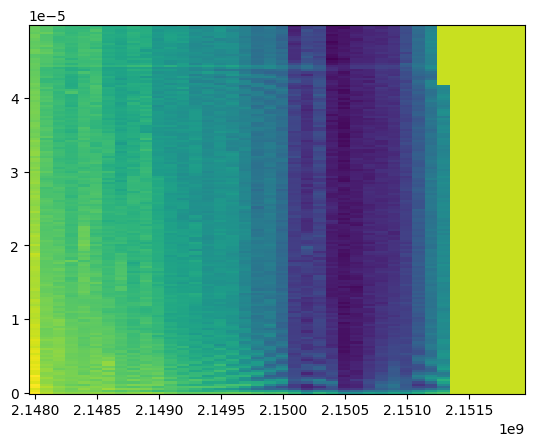

In [27]:
rabi_map.measure(alazar,
            awg,
            0,
            att,
            RFsourceMeasurement,
            0,
            Voltsource,
            freqMeasurement,
            RFSource_frequency_initial,
            RFSource_frequency_final,
            RFSource_frequency_step,
            voltage,
            rf_excitation_amp,
            rf_measurement_amp,
            attenuator_att,
            pulseExcitationLength_init,
            pulseExcitationLength_final,
            pulseExcitationLength_step,
            if_freq,
            qubitname,
            voltageSourceState,
            nBuffer,
            recordPerBuffers,
            waveformHeadCut,
            pulsesPeriod,
            pulseMeasurementLength,
            delayBetweenPulses,
            ampReference,
            decimation_value,
            excitationPulseIFAmp,
            currentResistance=1e3)

In [30]:
data.files

['header', 'duration', 'Z']

In [27]:
data = np.load('olivier_sample_20231023_2116_rabi_cfreq_7350.npz')

In [28]:
print(data['header'])

    #freqMeasurement: 7350000000.0
    #freqExcitation: 2150000000.0
    #voltage: -0.15
    #rf_excitation_amp: 14
    #rf_measurement_amp: 18
    #attenuator_att: 20
    #pulseExcitationLength_init: 0.0
    #pulseExcitationLength_final: 5e-05
    #pulseExcitationLength_step: 5e-07
    #if_freq: 70000000.0
    #qubitname: olivier_sample
    #voltageSourceState: True
    #nBuffer: 100
    #recordPerBuffers: 500
    #waveformHeadCut: 500
    #pulsesPeriod: 0.00058
    #pulseMeasurementLength: 5e-06
    #delayBetweenPulses: 0
    #ampReference: -9
    #decimation_value: 1
    #currentResistance: 1000.0
    #HOW TO PLOT
    data = np.load('olivier_sample_20231023_2116_rabi_cfreq_7350.npz')
    freqs = data['freqs']
    mag = np.abs(data['Z'])
    phase = np.unwrap(np.angle(data['Z']))
    fig = plt.figure(figsize=(10,7))
    ax = fig.gca()
    plt.plot(freqs*1e-6,20*np.log10(mag))
    ax.tick_params(labelsize=20)
    ax.set_xlabel('Frequency (MHz)',fontsize=20)
    ax.set_ylabel('S21 (dB)

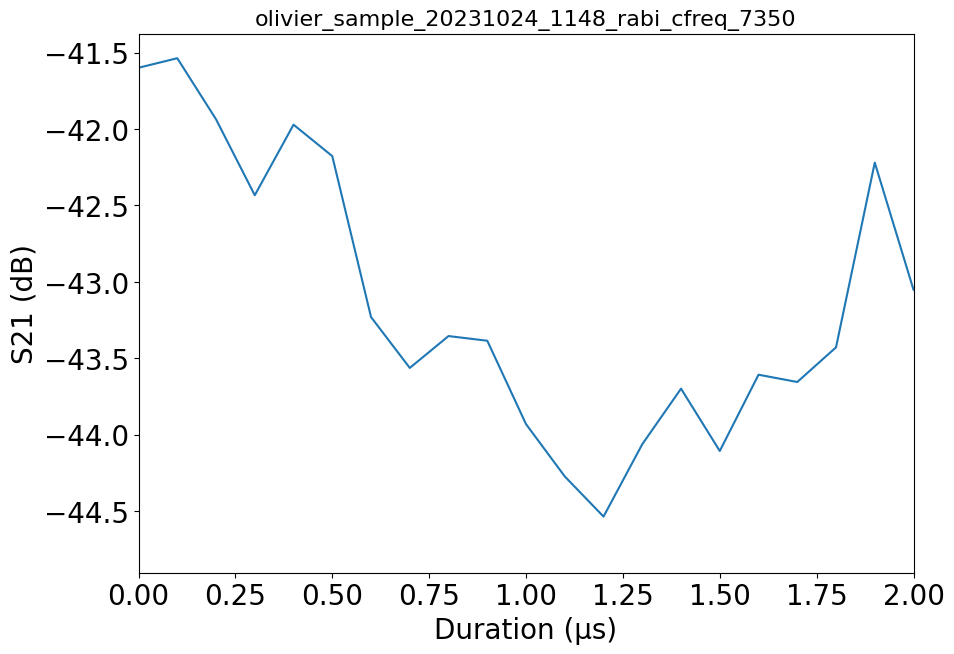

In [47]:
#freqMeasurement: 7350000000.0
#freqExcitation: 2150000000.0
#voltage: -0.15
#rf_excitation_amp: 14
#rf_measurement_amp: 18
#attenuator_att: 20
#pulseExcitationLength_init: 0.0
#pulseExcitationLength_final: 5e-05
#pulseExcitationLength_step: 5e-07
#if_freq: 70000000.0
#qubitname: olivier_sample
#voltageSourceState: True
#nBuffer: 100
#recordPerBuffers: 500
#waveformHeadCut: 500
#pulsesPeriod: 0.00058
#pulseMeasurementLength: 5e-06
#delayBetweenPulses: 0
#ampReference: -9
#decimation_value: 1
#currentResistance: 1000.0
#HOW TO PLOT
data = np.load('olivier_sample_20231024_1148_rabi_cfreq_7350.npz')
duration = data['duration']
mag = np.abs(data['Z'])
phase = np.unwrap(np.angle(data['Z']))
fig = plt.figure(figsize=(10,7))
ax = fig.gca()
plt.plot(duration*1e6,20*np.log10(mag))
ax.tick_params(labelsize=20)
ax.set_xlabel('Duration (µs)',fontsize=20)
ax.set_ylabel('S21 (dB)',fontsize=20)
ax.set_title('olivier_sample_20231024_1148_rabi_cfreq_7350',fontsize=16)
plt.xlim(0,2)
plt.show()

# T1

In [8]:
reload(T1)

<module 'measurements.T1' from 'C:\\Users\\Franscisco Rouxinol\\Developer\\MeasurementLFDQ\\src\\measurements\\T1.py'>

In [95]:
voltage = -0.15
rf_amp = 18
attenuator_att = 20
freqMeasurement = 7350e6
if_freq = 70e6
qubitname = 'olivier_sample'
voltageSourceState = True
nBuffer = 25
recordPerBuffers = 50
waveformHeadCut = 500
pulsesPeriod = 580e-6
pulseMeasurementLength = 5e-6
delayBetweenPulses = 0
ampReference = -9
decimation_value = 1 #  1 GHz/ decimation_value

rf_excitation_amp = -10
rf_measurement_amp= 18
durationExcitation = 800e-9

delayBetweenPulses_init = 0
delayBetweenPulses_final = 800E-6
delayBetweenPulses_step = 10e-6

excitationPulseIFAmp = 0.2

freqExcitation = 2150e6

excitationState = True

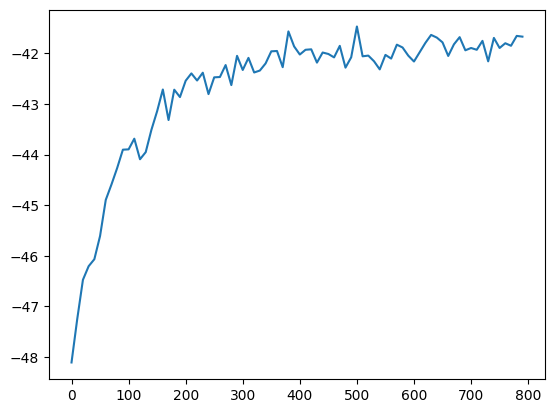

'olivier_sample_20231024_1701_T1_cfreq_7350.npz'

In [96]:
T1.measure(alazar,
        awg, 
        att,
        RFsourceMeasurement,
        0,
        Voltsource,
        freqMeasurement,
        freqExcitation,
        durationExcitation,
        voltage,rf_excitation_amp,
        rf_measurement_amp,
        attenuator_att,
        if_freq,
        qubitname,
        voltageSourceState,
        excitationState,
        nBuffer,
        recordPerBuffers, 
        waveformHeadCut,
        pulsesPeriod,
        pulseMeasurementLength,
        delayBetweenPulses_init,
        delayBetweenPulses_final, 
        delayBetweenPulses_step,
           excitationPulseIFAmp,
        ampReference,
        decimation_value,
        currentResistance=1e3)

In [23]:
data = np.load('olivier_sample_20231023_2210_T1_cfreq_7350.npz')

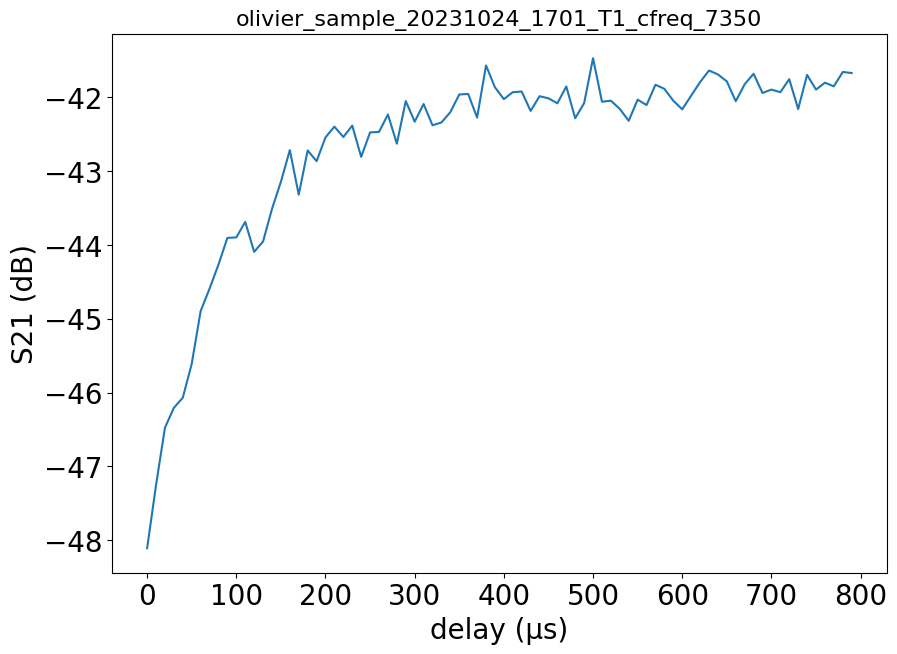

In [97]:
#freqMeasurement: 7350000000.0
#freqExcitation: 2150000000.0
#durationExcitation: 2e-06
#voltage: -0.15
#rf_excitation_amp: -10
#rf_measurement_amp: 18
#attenuator_att: 20
#if_freq: 70000000.0
#qubitname: olivier_sample
#voltageSourceState: True
#excitationState: True
#nBuffer: 25
#recordPerBuffers: 20
#waveformHeadCut: 500
#pulsesPeriod: 0.00058
#pulseMeasurementLength: 5e-06
#delayBetweenPulses_init: 0
#delayBetweenPulses_final: 0.0008
#delayBetweenPulses_step: 1e-05
#ampReference: -9
#decimation_value: 1
#currentResistance: 1000.0
#HOW TO PLOT
data = np.load('olivier_sample_20231024_1701_T1_cfreq_7350.npz')
delay = data['delay']
mag = np.abs(data['Z'])
phase = np.unwrap(np.angle(data['Z']))
fig = plt.figure(figsize=(10,7))
ax = fig.gca()
plt.plot(delay*1e6,20*np.log10(mag))
ax.tick_params(labelsize=20)
ax.set_xlabel('delay (µs)',fontsize=20)
ax.set_ylabel('S21 (dB)',fontsize=20)
ax.set_title('olivier_sample_20231024_1701_T1_cfreq_7350',fontsize=16)
plt.show()



In [98]:

def fT1(time, Const, Slope, T):   
    """
    Rabi curve using exponential decay: Const + Slope*exp(-time/Tr)*cos(2*pi*time/Period+Phase)

    """
    return (Const + Slope*np.exp(-time/T))

def fT1_g(time, Const,Const1, Slope, T):
    """
    Rabi curve using gaussianan decay: Const + amp * N.exp(-0.5*((x-pos)/(wid))**2)

    """
    return (Const + Slope*np.exp(-0.5*(time+Const1)/T)**2)


In [99]:
# T1 exponential

from scipy.optimize import curve_fit
args_T1 = [0.0045,-0.002,100e-6] # initial parameter to fit
"""
[Const, Slope,T1]{Const + Slope*exp(-time/T1)}
"""
popt,pcov = curve_fit(fT1, delay, mag, p0=args_T1)   
#print(r'T1 (Exponential): {0:.2f} +- {1:.2f} µs'.format(popt[2]*1e6,pcov[2]*1e6))



In [100]:
popt[2]*1e6

119.22556090086299

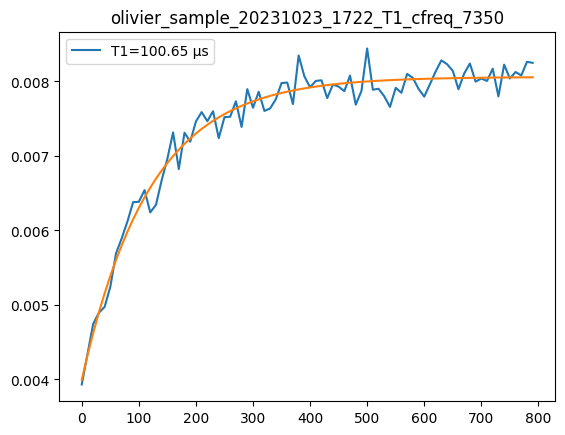

In [101]:
plt.plot(delay*1e6,mag)
plt.plot(delay*1e6,fT1(delay,*popt))
plt.title('olivier_sample_20231023_1722_T1_cfreq_7350')
plt.legend(['T1=100.65 µs'])

In [102]:
reload(ramsey)

<module 'measurements.ramsey' from 'C:\\Users\\Franscisco Rouxinol\\Developer\\MeasurementLFDQ\\src\\measurements\\ramsey.py'>

In [113]:
voltage = -0.15
rf_amp = 18
attenuator_att = 20
freqMeasurement = 7350e6
if_freq = 70e6
qubitname = 'olivier_sample'
voltageSourceState = True
nBuffer = 200
recordPerBuffers = 1000
waveformHeadCut = 500
pulsesPeriod = 580e-6
pulseMeasurementLength = 5e-6
delayBetweenPulses = 0
ampReference = -9
decimation_value = 1 #  1 GHz/ decimation_value

rf_excitation_amp = 0.2
rf_measurement_amp= 18
durationExcitation = 400e-9

delayBetweenPulses_init = 0
delayBetweenPulses_final = 20E-6
delayBetweenPulses_step = 100e-9

freqExcitation = 2150e6

awg.stop()
try:
    get_error(awg._session,'')
except ValueError:
    pass

'olivier_sample_20231024_1921_ramsey_cfreq_7350.npz'

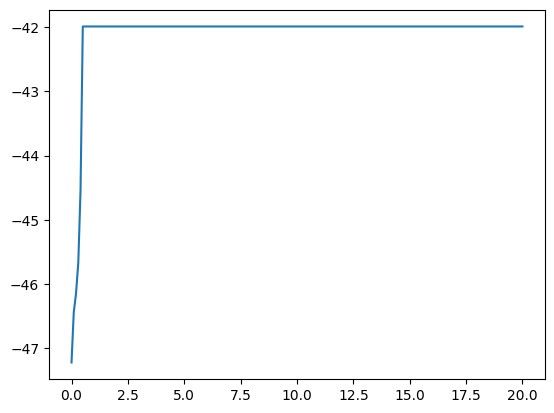

In [114]:
ramsey.measure(alazar,
            awg,
            att,
            RFsourceMeasurement,
            Voltsource,
            freqMeasurement,
            freqExcitation,
            durationExcitation,
            voltage,
            rf_excitation_amp,
            rf_measurement_amp,
            attenuator_att,
            if_freq,
            qubitname,
            voltageSourceState,
            nBuffer,
            recordPerBuffers,
            waveformHeadCut,
            pulsesPeriod,
            pulseMeasurementLength,
            delayBetweenPulses_init,
            delayBetweenPulses_final,
            delayBetweenPulses_step,
            ampReference,
            decimation_value,
            currentResistance=1e3,
            saveData = True)

In [50]:
data = np.load('olivier_sample_20231024_1155_ramsey_cfreq_7350.npz')

In [13]:
print(data['header'])

    #freqMeasurement: 7350000000.0
    #freqExcitation: 2150000000.0
    #durationExcitation: 1e-06
    #voltage: -0.15
    #rf_excitation_amp: 0.075
    #rf_measurement_amp: 18
    #attenuator_att: 20
    #if_freq: 70000000.0
    #qubitname: olivier_sample
    #voltageSourceState: True
    #nBuffer: 25
    #recordPerBuffers: 50
    #waveformHeadCut: 500
    #pulsesPeriod: 0.00058
    #pulseMeasurementLength: 5e-06
    #delayBetweenPulses_init: 0
    #delayBetweenPulses_final: 2e-05
    #delayBetweenPulses_step: 1e-07
    #ampReference: -9
    #decimation_value: 1
    #currentResistance: 1000.0
    #HOW TO PLOT
    data = np.load('olivier_sample_20231024_1057_ramsey_cfreq_7350.npz')
    delays = data['delays']
    mag = np.abs(data['Z'])
    phase = np.unwrap(np.angle(data['Z']))
    fig = plt.figure(figsize=(10,7))
    ax = fig.gca()
    plt.plot(delays*1e6,20*np.log10(mag))
    ax.tick_params(labelsize=20)
    ax.set_xlabel('Delay (us)',fontsize=20)
    ax.set_ylabel('S21 (dB)',fonts

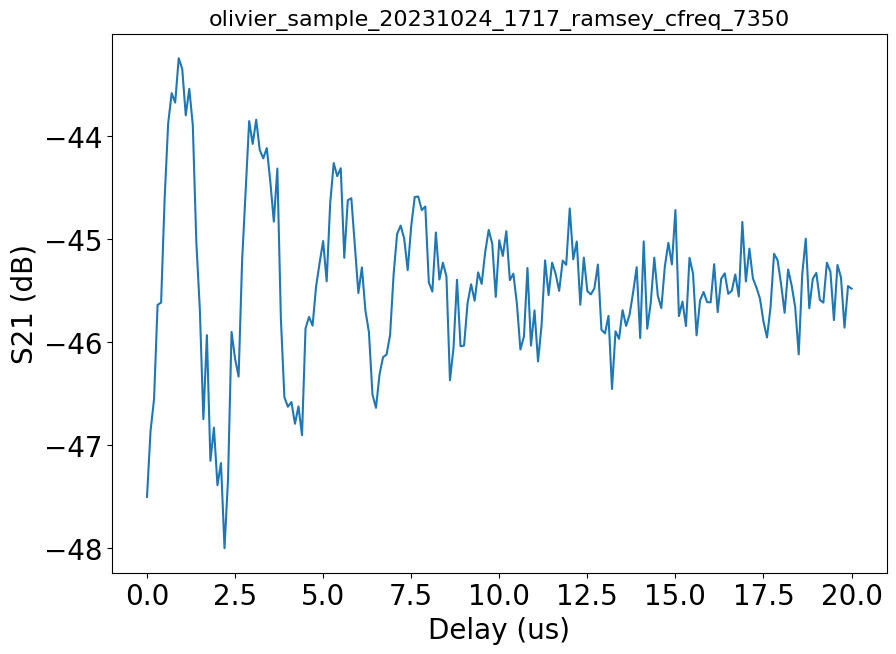

In [105]:
#freqMeasurement: 7350000000.0
#freqExcitation: 2150000000.0
#durationExcitation: 1e-06
#voltage: -0.15
#rf_excitation_amp: 0.075
#rf_measurement_amp: 18
#attenuator_att: 20
#if_freq: 70000000.0
#qubitname: olivier_sample
#voltageSourceState: True
#nBuffer: 25
#recordPerBuffers: 20
#waveformHeadCut: 500
#pulsesPeriod: 0.00058
#pulseMeasurementLength: 5e-06
#delayBetweenPulses_init: 0
#delayBetweenPulses_final: 5e-05
#delayBetweenPulses_step: 1e-08
#ampReference: -9
#decimation_value: 1
#currentResistance: 1000.0
#HOW TO PLOT
data = np.load('olivier_sample_20231024_1717_ramsey_cfreq_7350.npz')
delays = data['delays']
mag = np.abs(data['Z'])
phase = np.unwrap(np.angle(data['Z']))
fig = plt.figure(figsize=(10,7))
ax = fig.gca()
plt.plot(delays*1e6,20*np.log10(mag))

ax.tick_params(labelsize=20)
ax.set_xlabel('Delay (us)',fontsize=20)
ax.set_ylabel('S21 (dB)',fontsize=20)
ax.set_title('olivier_sample_20231024_1717_ramsey_cfreq_7350',fontsize=16)
plt.show()

In [106]:
###########################
  ###T2 #T2 #T2 #T2 #T2 # T2 ##########


# def T2(time, Const, Slope,Tr,Period,Phase):

# 	"""
# 	T2 curve using: Const + Slope*exp(-time/Tr)*cos(2*pi*time/Period+Phase)

# 	"""
# 	return (Const + Slope*exp(-time/Tr)*cos(2*pi*time*Period+Phase))

def Ramsey_g(time, Const, Slope,Tr,freq,Phase):
#     Const,Const1, Slope,Tr,freq,Phase = args
    """
    T2 curve using gaussian decay: (Const + Slope*exp(-0.5*((time-Const1)/Tr)**2)*cos( (2*pi*time/freq) + Phase))
    """
    
    return  (Const + Slope*np.exp(-0.5*(time/Tr)**2)*np.cos( (2*np.pi*time/freq) + Phase))

def Ramsey_e(time, Const, Slope,Tr,freq,Phase):
    
#     Const, Const1, Slope, Tr, freq, Phase = args
    """
    T2 curve using exponential decay: (Const + Slope*exp(-0.5*((time-Const1)/Tr)**2)*cos( (2*pi*time/freq) + Phase))
    """
    return (Const + Slope*np.exp(-time/Tr)*np.cos( (2*np.pi*time/freq) + Phase))
def Fit_Ramsey(Func,Time, Amp, Sigma, pars):
    """
    Fit Ramsey curve using: T1 exp or T1 gaussinan
        - Choose T1_e or T1_g
    Time: x axis array of values
    Amplitude: Matrix with the multiple curves 
    where args are:
    * Const
    * Slope
    * T1
    Return the fit values and the standard deviation
    """
    Const,Const1, Slope, Tr, freq, Phase = pars
#     print(pars)
    if Func == 'gauss':
        Func = Ramsey_g
        args = Const, Slope, Tr, freq, Phase #pars
    elif Func == 'exp':
        Func = Ramsey_e
        args = Const, Slope, Tr, freq, Phase
        
    popt, pcov = curve_fit(Func, Time, Amp, p0=args, sigma=Sigma, absolute_sigma=False,maxfev=10000,ftol=1e-20 )   
    
    
    return popt, sqrt(diag(pcov))
    

In [107]:
# Const, Slope, Tr, freq, Phase
# initial parameter to fit
args_T2 = [6e-03,0.002,10e-6,2e-6,91] 

In [108]:
from scipy.optimize import curve_fit
# T2 exponential'


popt_e,pcov_e = curve_fit(Ramsey_e,delays,mag,args_T2,maxfev=100000,ftol=1e-30 )
#print(r'Rabi time (Exponential): {0:.2f} +- {1:.2f} µs'.format(popt_e[2]*1e6,pcov_e[2]*1e6))



In [109]:
popt_e[2]*1e6

5.534229419390482

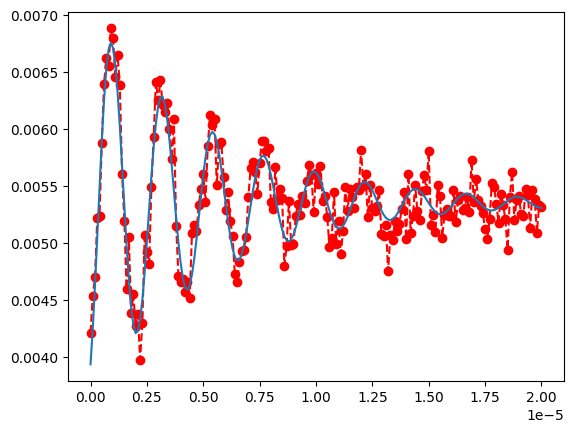

In [110]:
plt.plot(delays,mag,'r--o')
plt.plot(delays,Ramsey_e(delays,*popt_e))

In [57]:
voltage = -0.15
rf_amp = 18
attenuator_att = 20
freqMeasurement = 7350e6
if_freq = 70e6
qubitname = 'olivier_sample'
voltageSourceState = True
nBuffer = 25
recordPerBuffers = 50
waveformHeadCut = 500
pulsesPeriod = 580e-6
pulseMeasurementLength = 5e-6
delayBetweenPulses = 0
ampReference = -9
decimation_value = 1 #  1 GHz/ decimation_value

rf_excitation_amp = 0.075
rf_measurement_amp= 18
durationExcitation = 600e-9

delayBetweenPulses_init = 0
delayBetweenPulses_final = 20E-6
delayBetweenPulses_step = 100e-9

freqExcitation = 2150e6

awg.stop()
try:
    get_error(awg._session,'')
except ValueError:
    pass
    

In [61]:
reload(echo)

<module 'measurements.echo' from 'C:\\Users\\Franscisco Rouxinol\\Developer\\MeasurementLFDQ\\src\\measurements\\echo.py'>

'olivier_sample_20231024_1210_echo_cfreq_7350.npz'

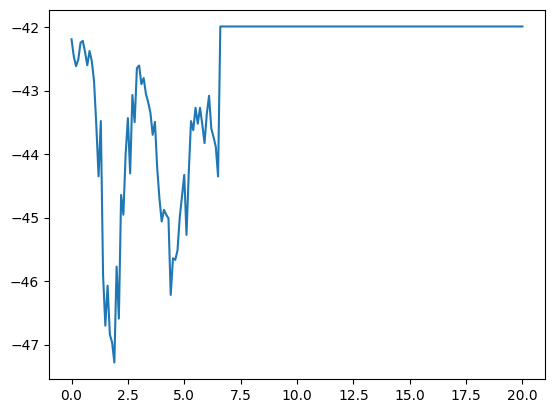

In [62]:
echo.measure(alazar,
            awg,
            att,
            RFsourceMeasurement,
            Voltsource,
            freqMeasurement,
            freqExcitation,
            durationExcitation,
            voltage,
            rf_excitation_amp,
            rf_measurement_amp,
            attenuator_att,
            if_freq,
            qubitname,
            voltageSourceState,
            nBuffer,
            recordPerBuffers,
            waveformHeadCut,
            pulsesPeriod,
            pulseMeasurementLength,
            delayBetweenPulses_init,
            delayBetweenPulses_final,
            delayBetweenPulses_step,
            ampReference,
            decimation_value,
            currentResistance=1e3,
            saveData = True)